# Multiple techniques for regression algorithm (MTFRA)

Este notebook tiene como objetivo entrenar multiples algoritmos de regresión sobre multiples conjuntos de datos, para esto se desarrolla una programación estructurada, donde la idea principal es interactuar con el main, donde se debe cambiar el tipo de algoritmo. Unas lineas más arriba se puede seleccionar el conjunto de datos con el que se va a trabajar.

## Importar librerias

In [ ]:
import os
import cv2
import time
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

Se ejecuta un ciclo que recorre la carpeta de origen del conjunto de datos y busca sobre todos los archivos que inicien con $\text{.csv}$, de tal forma que se puedan adjuntar a una lista que contenga cada uno de los conjuntos de datps y sea sencilla de indexar.

In [2]:
all_data = []
for data_frame in glob.glob("*.csv"):
    data = pd.read_csv(str(data_frame))
    all_data.append(data)

Se selecciona el conjunto de datos con el que se va a trabajar posibles opciones: $[0,1,2,3]$

In [4]:
# data_set_number = 0,1,2,3
data_set_number = 2
data_select = all_data[data_set_number]

In [5]:
data_select

,surface_tension,molecular_formula,density_liquid,enthalpy_fusion,enthalpy_vaporization,enthalpy_vaporization_boiling,thermal_expansion,C,Br,Cl,O,F,H,N,I,Si,S,Al,Ga,molecular_weight
0,2.06,CH3F,0.5283,1.426,15.686,17.670,0.008332,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,34.032966
1,3.01,C2H3F,0.6150,2.736,16.219,18.322,0.006303,2.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,46.043706
2,4.59,C2H3F3,1.0780,6.192,18.448,19.459,0.005488,2.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,84.040512
3,3.95,C2HF5,1.2166,2.250,18.372,19.147,0.005306,2.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,120.021437
4,6.08,C2HF3,1.2782,9.068,18.097,19.142,0.005126,2.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,82.024630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3372,11.46,C38H78,0.9101,85.444,72.163,71.757,0.000523,38.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,535.027518
3373,48.43,C2H6O2,1.1100,9.958,41.292,52.495,0.000455,2.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,62.067936
3374,53.72,C6H15Al,0.8350,10.600,44.632,60.677,0.000391,6.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,1.0,0.0,114.165093
3375,39.11,C7H9N,0.9810,13.400,40.107,43.871,0.000383,7.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,107.153352


## Normalización de los datos

Se tienen los datos en su estado natural y se normalizan con el StandarScaler de Scikitlearn, teniendo en cuenta que:

$z = \frac{X-\mu}{\sigma}$,

Donde $\mu$ y $\sigma$ son la media y la desviación estandar por columna.
Además, se divide el conjunto de datos en entrenamiento y prueba.

In [60]:
X = np.array(data_select.iloc[:,2:24])
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
y = np.array(data_select['surface_tension'])
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, random_state=42)

In [65]:
new_array = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
new_array.shape

(507, 19)

## Correlación entre los datos

Se determina qué tan relacionado están los datos a partir del calculo de la matriz de correlación. 

In [7]:
M_corr = np.corrcoef(X_norm, rowvar=False)

In [8]:
labels_ft= list(data_select.columns)[2:24]

In [9]:
position = []
for i in range(len(M_corr)):
    for j in range(len(M_corr)):
        if M_corr[i][j] > 0.85 or M_corr[i][j] < -0.85:
            position.append((labels_ft[i], labels_ft[j]))

In [10]:
def remove_duplicates(list_of_tuples):
    seen = set()
    result = []
    for item in list_of_tuples:
        if item[0] != item[1]:
            sorted_item = tuple(sorted(item))
            if sorted_item not in seen:
                seen.add(sorted_item)
                result.append(item)
    return result

In [11]:
var_corr = remove_duplicates(position)

In [12]:
var_corr

[('enthalpy_vaporization', 'enthalpy_vaporization_boiling'), ('C', 'H')]

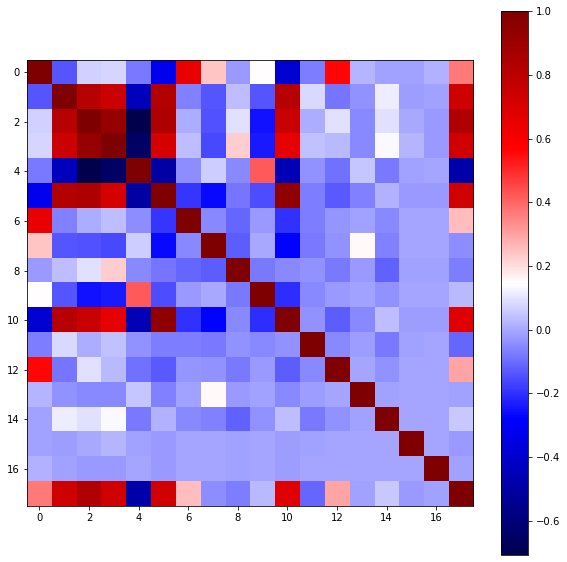

In [13]:
plt.figure(figsize=(10, 10))
plt.imshow(M_corr, cmap="seismic")
plt.colorbar()
plt.savefig(f"CM_data_set_number_{data_set_number}")
plt.show()

## Función para la busqueda de hyperparametros sobre los clasificadores.

Se define una función que recibe por parametros el tipo de regresión que se va a realizar, además de los datos de entrenamiento, esta función devuelve un diccionario con los mejores parametros para cada tipo de clasificador. Al regresor lineal no se le realiza esta busqueda debido a que no tiene parámetros para buscar. 

In [14]:
def parameters_search(reg_type, X_train, y_train):
    hyperparameters = {}
    parameters = {}
    start_time = time.time()
    if reg_type == "linear_regression":
        pass
    elif reg_type == "KNN_regression":
        hyperparameters = {'n_neighbors': [int(x) for x in np.linspace(start=1, stop=20, num=10)],
                           'weights': ['uniform', 'distance'],
                           'algorithm': ['ball_tree', 'kd_tree'],
                           'leaf_size': [int(x) for x in np.linspace(1, 30, num=10)]}
        regressor = KNeighborsRegressor()
    elif reg_type == "RF_regression":
        hyperparameters = {'max_features': ["sqrt","log2"],
                          'n_estimators': [int(x) for x in np.linspace(start=1, stop=50, num=10)],
                          'max_depth': [int(x) for x in np.linspace(1, 110, num=10)],
                          'min_samples_split': [2, 4, 5, 6],
                          'min_samples_leaf': [1, 2, 4, 8],
                          "bootstrap": [True]}
        regressor = RandomForestRegressor()
    elif reg_type == "XGB_regression":
        hyperparameters = {"max_depth":[2, 4, 6],
                          "n_estimators": [100, 200, 300],
                          "learning_rate": [0.001, 0.015, 0.1]}
        regressor = XGBRegressor()
    else:
        raise ValueError("Invalid regressor type")

    search = GridSearchCV(regressor, hyperparameters, cv=3, verbose=3)
    parameters = search.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    print("Elapsed time:", elapsed_time)
    return parameters

## Función para el entrenamiento de cada algoritmo

También, se realiza una función para el entrenamiento de cada uno de los tipos de regresión lineal, de tal forma que se recibe como entrada los datos de entrnamiento (x_train, y_train), el tipo de regresor y la lista de parámetros que encuentra la funcióm anterior. Esta función retorna el modelo entrenado con los mejores parámetros.

In [15]:
def regressor(reg_type, parameters, X_train, y_train):
    if reg_type == "linear_regression":
        linear_reg = LinearRegression()
        model = linear_reg.fit(X_train,y_train)
    elif reg_type == "KNN_regression":
        KNN_regression = KNeighborsRegressor(**parameters)
        model = KNN_regression.fit(X_train,y_train)
    elif reg_type == "RF_regression":
        RF_regression = RandomForestRegressor(**parameters)
        model = RF_regression.fit(X_train,y_train)
    elif reg_type == "XGB_regression":
        XGB_regression = XGBRegressor(**parameters)
        model = XGB_regression.fit(X_train,y_train)
    return model 

## Principal

Acá se modifica el tipo de regresión que se va a utilizar, basta con reemplzar el string asignado a la variable $\text{reg_type}$ y la progrmación modular que se hizo anteriomente hará el resto del trabajo.

In [16]:
model_linear = model = regressor("linear_regression", _, X_train, y_train)
best_parameters_KNN = parameters_search("KNN_regression", X_train, y_train)
model_KNN = regressor("KNN_regression", best_parameters_KNN.best_params_, X_train, y_train)
best_parameters_RF = parameters_search("RF_regression", X_train, y_train)
model_RF = regressor("RF_regression", best_parameters_RF.best_params_, X_train, y_train)
best_parameters_XGB = parameters_search("XGB_regression", X_train, y_train)
model_XGB = regressor("XGB_regression", best_parameters_XGB.best_params_, X_train, y_train)
print("Done!")

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
[CV 1/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.759 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.759 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, weights=uniform;, score=0.368 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=1, n_neighbors=3, weights=uniform;, score=0.773 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=1

[CV 2/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, weights=uniform;, score=0.743 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, weights=uniform;, score=0.799 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.366 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.768 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.823 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.355 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.726 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=4, n_neighbors=7, weights=distance;, score=0.365 total time=   0.

[CV 1/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=9, weights=distance;, score=0.360 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=9, weights=distance;, score=0.746 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=9, weights=distance;, score=0.825 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.334 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.709 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.789 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.346 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.740 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.821 total ti

[CV 1/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=uniform;, score=0.312 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=uniform;, score=0.698 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=uniform;, score=0.763 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.329 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.733 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.306 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.685 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.753

[CV 1/3] END algorithm=ball_tree, leaf_size=13, n_neighbors=20, weights=distance;, score=0.330 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=13, n_neighbors=20, weights=distance;, score=0.718 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=13, n_neighbors=20, weights=distance;, score=0.794 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=uniform;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=uniform;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.760 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.695 to

[CV 2/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform;, score=0.743 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=uniform;, score=0.799 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance;, score=0.366 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance;, score=0.768 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=5, weights=distance;, score=0.823 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, weights=uniform;, score=0.355 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, weights=uniform;, score=0.726 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, weights=uniform;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=20, n_neighbors=7, weights=distance;, score=0.365 total t

[CV 3/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=9, weights=uniform;, score=0.796 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=9, weights=distance;, score=0.360 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=9, weights=distance;, score=0.746 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=9, weights=distance;, score=0.825 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=11, weights=uniform;, score=0.334 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=11, weights=uniform;, score=0.709 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=11, weights=uniform;, score=0.789 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=11, weights=distance;, score=0.346 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=23, n_neighbors=11, weights=distance;, score=0.740 t

[CV 1/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=uniform;, score=0.312 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=uniform;, score=0.698 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=uniform;, score=0.763 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=distance;, score=0.329 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=distance;, score=0.733 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=15, weights=distance;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=17, weights=uniform;, score=0.306 total time=   0.0s
[CV 2/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=17, weights=uniform;, score=0.685 total time=   0.0s
[CV 3/3] END algorithm=ball_tree, leaf_size=26, n_neighbors=17, weights=uniform;, score=0.753

[CV 3/3] END algorithm=ball_tree, leaf_size=30, n_neighbors=20, weights=distance;, score=0.794 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.759 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=uniform;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.759 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=1, weights=distance;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, weights=uniform;, score=0.368 total time=   0.1s
[CV 2/3] END algorithm=kd_tree, leaf_size=1, n_neighbors=3, weights=uniform;, score=0.773 total time=   0.1s
[CV 3/3] EN

[CV 3/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=5, weights=uniform;, score=0.799 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.366 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.768 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=5, weights=distance;, score=0.823 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.355 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.726 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=7, weights=uniform;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=7, weights=distance;, score=0.365 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=4, n_neighbors=7, weights=distance;, score=0.753 total time=   0.0s
[CV 3/3] END a

[CV 1/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.334 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.709 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=uniform;, score=0.789 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.346 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.740 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=11, weights=distance;, score=0.821 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=13, weights=uniform;, score=0.322 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=13, weights=uniform;, score=0.703 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=7, n_neighbors=13, weights=uniform;, score=0.774 total time=   0.0s
[CV 1/3

[CV 1/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.329 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.733 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=15, weights=distance;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.306 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.685 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=uniform;, score=0.753 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=distance;, score=0.323 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=distance;, score=0.724 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=10, n_neighbors=17, weights=distance;, score=0.802 total time=   

[CV 1/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.388 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.760 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=1, weights=distance;, score=0.695 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=uniform;, score=0.368 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=uniform;, score=0.773 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=uniform;, score=0.804 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=distance;, score=0.373 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=distance;, score=0.787 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=17, n_neighbors=3, weights=distance;, score=0.820 total time=   0.0s
[CV 

[CV 2/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, weights=uniform;, score=0.726 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, weights=uniform;, score=0.807 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, weights=distance;, score=0.365 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, weights=distance;, score=0.753 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=7, weights=distance;, score=0.832 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, weights=uniform;, score=0.349 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, weights=uniform;, score=0.716 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, weights=uniform;, score=0.796 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=20, n_neighbors=9, weights=distance;, score=0.360 total time=   0.0s
[CV 2/

[CV 1/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=uniform;, score=0.322 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=uniform;, score=0.703 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=uniform;, score=0.774 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=distance;, score=0.336 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=distance;, score=0.736 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=13, weights=distance;, score=0.813 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=15, weights=uniform;, score=0.312 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=15, weights=uniform;, score=0.698 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=23, n_neighbors=15, weights=uniform;, score=0.763 total time=   0.0

[CV 1/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=17, weights=distance;, score=0.323 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=17, weights=distance;, score=0.724 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=17, weights=distance;, score=0.802 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=uniform;, score=0.310 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=uniform;, score=0.671 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=uniform;, score=0.739 total time=   0.0s
[CV 1/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=distance;, score=0.330 total time=   0.0s
[CV 2/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=distance;, score=0.718 total time=   0.0s
[CV 3/3] END algorithm=kd_tree, leaf_size=26, n_neighbors=20, weights=distance;, score=0.794 total time=   

[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.166 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.145 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.104 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.176 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.193 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.112 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.188 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.106 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.106 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.174 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.104 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.140 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.092 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.178 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.228 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.135 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.169 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.118 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.201 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.120 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.161 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.247 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.088 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.138 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.126 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.236 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.144 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.092 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.180 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.185 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.113 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.174 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.233 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.109 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.204 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.238 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.108 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.179 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.193 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.122 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.230 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.210 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.229 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.197 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.091 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.209 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.219 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.106 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.210 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.120 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.203 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.096 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.099 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.141 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.149 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.203 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.101 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.192 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.187 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.105 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.279 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.098 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.198 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.183 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.091 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.195 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.159 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.086 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.126 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.195 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.130 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.187 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.102 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.162 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.176 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.105 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.153 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.182 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.203 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.110 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.180 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.217 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.095 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.158 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.133 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.208 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.216 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.115 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.225 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.187 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.219 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.117 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.225 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.235 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.111 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.216 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.767 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.844 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.447 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.794 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.420 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.409 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.446 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.766 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.860 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.457 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.793 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.437 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.713 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.852 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.513 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.834 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.454 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.411 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.729 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.428 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.674 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.699 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=6;, score=0.452 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=6;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.420 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.849 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.426 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.771 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.390 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.824 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.376 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.813 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.492 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.811 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.852 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.518 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.778 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.478 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.771 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.459 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.788 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sam

[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.454 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.841 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.469 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.778 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sam

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.497 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.765 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.845 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.463 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.868 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.437 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.770 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.859 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.409 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.838 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.809 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.452 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.832 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.404 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samp

[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.580 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.687 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.381 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.715 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples

[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.400 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.736 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.397 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.791 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.874 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.478 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.880 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.465 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.802 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.509 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.806 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.441 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.461 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.869 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.461 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.438 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.809 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.477 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.806 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.441 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.738 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.397 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.743 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.422 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.767 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.411 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.732 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.453 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.860 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.470 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.792 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.478 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.800 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.867 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.471 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.868 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.840 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.446 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.728 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.510 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.773 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sam

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.877 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.451 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.733 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=-0.022 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.490 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sample

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.874 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.464 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.799 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.870 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.444 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.785 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.412 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.429 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.397 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.817 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.800 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.387 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.739 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.402 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.425 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.436 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.879 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.469 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.774 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.489 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.789 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.863 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.820 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.456 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.462 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samp

[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.862 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.356 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.709 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.583 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.484 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.785 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.407 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.420 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.427 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.853 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.408 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.848 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.390 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.817 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.378 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.684 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.530 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.786 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.880 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.469 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.514 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.782 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.492 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.797 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.716 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.446 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.790 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.829 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.498 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samp

[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.862 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.317 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.629 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.760 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.426 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.702 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.457 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.788 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.868 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.445 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.794 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.869 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.414 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.774 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.844 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.425 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.442 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.777 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.416 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.767 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.835 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.743 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.394 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.684 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.549 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.883 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.474 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.770 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.468 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.788 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.874 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.307 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.504 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.612 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.484 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.440 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.798 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.871 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.453 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.788 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.457 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.869 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.435 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.794 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.404 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.853 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.387 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.815 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.385 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.746 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.805 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.384 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.465 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.453 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.805 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.512 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.878 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.475 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.838 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.458 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.799 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.441 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.796 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sam

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.870 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.292 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.179 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.756 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.446 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.771 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples

[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.429 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.780 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.875 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.468 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.799 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.768 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.849 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.410 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.775 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.858 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.422 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.852 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.419 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.777 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.859 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.421 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.831 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.368 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.827 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.405 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.503 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.795 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.803 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.479 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.858 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.811 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.874 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.456 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.624 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=-0.474 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.413 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.872 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.456 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.800 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.889 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.460 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.809 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.459 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.867 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.436 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.793 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.420 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.770 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.432 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.772 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.838 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.422 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.775 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.407 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.387 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.406 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.781 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.399 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.817 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.396 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.849 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.477 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.788 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.882 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.503 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.804 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.483 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.471 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.767 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.870 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.869 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.447 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.788 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.860 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.840 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.473 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sam

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.435 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.698 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.408 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sam

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.335 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.601 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.509 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=6;, score=0.411 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=6;, score=0.730 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.868 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.438 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.768 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.431 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.752 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.830 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.735 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.810 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.399 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.752 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.819 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.389 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.759 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.468 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.803 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.449 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.792 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.509 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.780 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.870 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.867 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.438 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.415 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samp

[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.792 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.875 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.426 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.271 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.680 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.481 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_sample

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.853 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.424 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.784 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.417 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.774 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.850 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.412 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.780 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.862 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.400 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.775 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.400 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.753 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.818 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.399 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.401 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.849 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.490 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.734 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.850 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.465 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.802 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6;, score=0.760 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=6;, score=0.827 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.447 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.699 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.452 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samp

[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.559 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.521 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.600 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.382 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=6;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples

[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.468 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.793 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.878 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.490 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.803 total time=   0.3s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.875 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.802 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.868 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.434 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.803 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.863 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.486 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.419 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.756 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.853 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.848 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.437 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.804 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.412 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.774 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.389 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.735 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.822 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.368 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.834 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.420 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.740 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.388 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.498 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.531 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.701 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.439 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=6;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.796 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.883 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.458 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.802 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.884 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.299 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.459 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.780 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.467 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.798 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.872 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.797 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.872 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.463 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.805 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.863 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.429 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.769 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.858 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.399 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.773 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.840 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.759 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.837 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.425 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.770 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.453 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=6;, score=0.808 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.834 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.383 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.738 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sam

[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.403 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.827 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.392 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.812 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.844 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.464 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.873 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.472 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.811 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.454 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.768 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.462 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.795 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.867 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.787 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.470 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.791 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.860 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.461 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.785 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.467 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.809 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.859 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.434 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.789 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.763 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.423 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.852 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.422 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.445 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.838 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.418 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.845 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.398 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.807 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.375 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.745 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.379 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.747 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.824 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.391 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.859 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.513 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.765 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.872 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.481 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.795 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.696 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6;, score=0.463 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6;, score=0.789 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.442 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.718 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.463 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.783 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.880 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.578 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.571 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.690 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sampl

[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.467 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.772 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.863 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.442 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.791 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.884 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.424 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.797 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.456 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.839 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.418 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.778 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.430 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=6;, score=0.809 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.418 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.763 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.405 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.786 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.838 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.311 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.596 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.632 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.388 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=6;, score=0.720 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples

[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.829 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.393 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.745 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.827 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.389 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.762 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.870 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.499 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.805 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.871 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.468 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.787 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.463 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.797 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.865 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.493 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.803 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.876 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.846 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.444 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.820 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.432 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.786 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.775 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=6;, score=0.826 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.458 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.766 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.855 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.451 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samp

[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.783 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.864 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.296 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.608 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.688 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.410 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sample

[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.769 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.877 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.427 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.754 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.859 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.421 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.843 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.397 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.763 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.845 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.427 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.393 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.759 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.814 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.374 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.744 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.828 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.725 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.816 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.390 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.815 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.386 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=11;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.485 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.859 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.480 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.764 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.836 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.474 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.802 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.866 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.470 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.754 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.816 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.874 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.464 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.781 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.856 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.441 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.829 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.477 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.761 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.833 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.443 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.787 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.437 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.762 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.854 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.402 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.749 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.861 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=11;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.437 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.853 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.433 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=11;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.371 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.748 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.846 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.365 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.731 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.083 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.354 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.697 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.803 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.408 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.884 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.459 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.800 total time=   0.1s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.878 total time=   0.1s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.443 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.139 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, m

[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.452 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.478 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.804 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1,

[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.774 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.872 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.447 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.799 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.875 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.448 total time=   0.1s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.779 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.851 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.436 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.792 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.862 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.462 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.417 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.783 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.849 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.407 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.772 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.409 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.757 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=11;, score=0.857 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.403 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.768 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.864 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.726 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.811 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.394 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.821 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.401 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.380 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.741 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.839 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.376 total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.755 total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.823 total time=   0.0s
[CV 1/3] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=200;, score=-8.256 total time=   0.1s
[CV 1/3] END learning_rate=0.001, max_depth=2, n_estimators=300;, score=-3.102 total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=2, n_estimators=300;, score=-6.432 total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=2, n_estimators=300;, score=-6.702 total time=   0.1s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=100;, score=-4.687 total time=   0.0s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=100;, score=-9.680 total time=   0.0s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=100;, score=-10.131 total time=   0.0s
[CV 1/3] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=-3.806 total time=   0.1s
[CV 2/3] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=-7.826 total time=   0.1s
[CV 3/3] END learning_rate=0.001, max_depth=4, n_estimators=200;, score=-8.208 total time=   0.1s
[CV 1/3] END learni

## Predicción a partir del modelo.

In [77]:
score_XGB = []
mse_XGB = []
score_RF = []
mse_RF = []
score_KNN = []
mse_KNN = []
score_linear = []
mse_linear = []
sample_size = 50
for i in range(100):
    sample_rows = np.random.choice(new_array.shape[0], size=sample_size, replace=False)
    y_true = new_array[sample_rows, [-1]] 
    chunk = new_array[sample_rows, 0:18]
    y_pred_XGB = model_XGB.predict(chunk)
    y_pred_XGB = y_pred_XGB.reshape(len(y_pred_XGB), 1)
    y_pred_RF = model_RF.predict(chunk)
    y_pred_RF = y_pred_RF.reshape(len(y_pred_RF), 1)
    y_pred_KNN = model_KNN.predict(chunk)
    y_pred_KNN = y_pred_KNN.reshape(len(y_pred_KNN), 1)
    y_pred_linear = model_linear.predict(chunk)
    y_pred_linear = y_pred_linear.reshape(len(y_pred_linear), 1)

    score_XGB.append(r2_score(y_true, y_pred_XGB))
    mse_XGB.append(mean_squared_error(y_true, y_pred_XGB))
    score_RF.append(r2_score(y_true, y_pred_RF))
    mse_RF.append(mean_squared_error(y_true, y_pred_RF))
    score_KNN.append(r2_score(y_true, y_pred_KNN))
    mse_KNN.append(mean_squared_error(y_true, y_pred_KNN))
    score_linear.append(r2_score(y_true, y_pred_linear))
    mse_linear.append(mean_squared_error(y_true, y_pred_linear))

In [82]:
np.mean(score_XGB)

0.8837863197413861

In [63]:
last_regression = LinearRegression()
last_model = last_regression.fit(y_test.reshape(len(y_test), 1), y_pred_XGB)
last_model.coef_

array([[0.81418956]])

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter(y_test.reshape(len(y_test), 1), y_pred, color='#f2c738') 
line = last_model.coef_*y_test
plt.plot(y_test.reshape(len(y_test), 1), line.reshape(len(y_test), 1), color='k') 
plt.title(f'Surface Tension Prediction {reg_type} data set {data_set_number}', fontsize=15)
plt.savefig(f"Surface_Tension_Prediction_type_{reg_type}_data_set_number_{data_set_number}")
plt.grid()
plt.show()

## Obtención de métricas.

In [64]:
score = r2_score(y_test, y_pred_XGB)
print("Mean squared error:", mean_squared_error(y_test, y_pred_XGB))
print("Coefficient of determination:", score)

Mean squared error: 11.3231324988291
Coefficient of determination: 0.8553897400241088


## Visualización de los resultados en conjunto.

In [ ]:
images = [cv2.imread(image) for image in glob.glob("*.png")]

In [ ]:
rows = 3
cols = 4
fig = plt.figure(figsize=(50, 25))
for j in range(0, rows*cols):
    plt.figure(figsize=(50, 25))
    plt.imshow(images[j])
    plt.axis("off")

## Comparación del rendimieto de cada algoritmo con respecto a cada conjunto de datos.

In [ ]:
method = ['Dataset 1','Dataset 2','Dataset 3', 'Dataset 4']
linear = [642.6876188301752, 168.26387687446982, 11.590650243118517, 19.705728878894277]
RF = [671.4807890872357, 10.298640887425638, 5.4628679326165015, 15.996548782003888]
KNN = [769.3726284227985, 14.270850460103263, 6.62079317440728, 15.74323356289647]

plt.figure(figsize=(15, 5))  
N = 4
ind = np.arange(N) 
width = 0.25

bar1 = plt.bar(ind, linear, width, color = 'r')
bar2 = plt.bar(ind+width, RF, width, color = 'g')
bar3 = plt.bar(ind+width*2, KNN, width, color = 'b')


plt.xlabel("Data set")
plt.ylabel('MSE Score')  
plt.xticks(ind+width,method)
plt.legend( (bar1, bar2, bar3), ('Linear', 'RF', 'KNN') )
plt.grid("on")
plt.show()


In [ ]:
method = ['Dataset 1','Dataset 2','Dataset 3', 'Dataset 4']
linear = [642.6876188301752, 168.26387687446982, 11.590650243118517, 19.705728878894277]
RF = [671.4807890872357, 10.298640887425638, 5.4628679326165015, 15.996548782003888]
KNN = [769.3726284227985, 14.270850460103263, 6.62079317440728, 15.74323356289647]

plt.figure(figsize=(15, 5))  
N = 4
ind = np.arange(N) 
width = 0.25

bar1 = plt.bar(ind, linear, width, color = 'r')
bar2 = plt.bar(ind+width, RF, width, color = 'g')
bar3 = plt.bar(ind+width*2, KNN, width, color = 'b')


plt.xlabel("Data set")
plt.ylabel('MSE Score')
plt.ylim([0, 170]) 
plt.xticks(ind+width,method)
plt.legend( (bar1, bar2, bar3), ('Linear', 'RF', 'KNN') )
plt.grid("on")
plt.show()

In [ ]:
method = ['Dataset 1','Dataset 2','Dataset 3', 'Dataset 4']
linear = [0.31458898214487874, -1.209831474846463, 0.7198763833155115, 0.7483337250989508]
RF = [0.28388175276166794, 0.864746603941901, 0.8679730394191827, 0.7957044944654832]
KNN = [0.1794824407586968, 0.8125790567449583, 0.8399882240915637, 0.7989396398366745]

plt.figure(figsize=(15, 5))  
N = 4
ind = np.arange(N) 
width = 0.25

bar1 = plt.bar(ind, linear, width, color = 'r')
bar2 = plt.bar(ind+width, RF, width, color = 'g')
bar3 = plt.bar(ind+width*2, KNN, width, color = 'b')


plt.xlabel("Data set")
plt.ylabel('$R^2$ Score')  
plt.xticks(ind+width,method)
plt.legend( (bar1, bar2, bar3), ('Linear', 'RF', 'KNN') )
plt.grid("on")
plt.show()

## Permutation feature importance

In [ ]:
def feature_importance(model):
    result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=0)
    return result

In [ ]:
importance = feature_importance(model)
mean = importance.importances_mean
tot = sum(mean)
hist=[]
for i in range(len(mean)):
    clc = (mean[i]*100)/tot
    hist.append(clc)
print(hist)

In [ ]:
labels_ft= list(data_select.columns)[2:24]
labels_ft

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(labels_ft, hist, color='#03859c')
plt.title(f'Permutation Feature Importance with {reg_type} and data set number {data_set_number}', 
          fontsize=15, fontweight="bold")
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance percentage', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.savefig(f"feature_importance_with_{reg_type}_data_set_number_{data_set_number}")

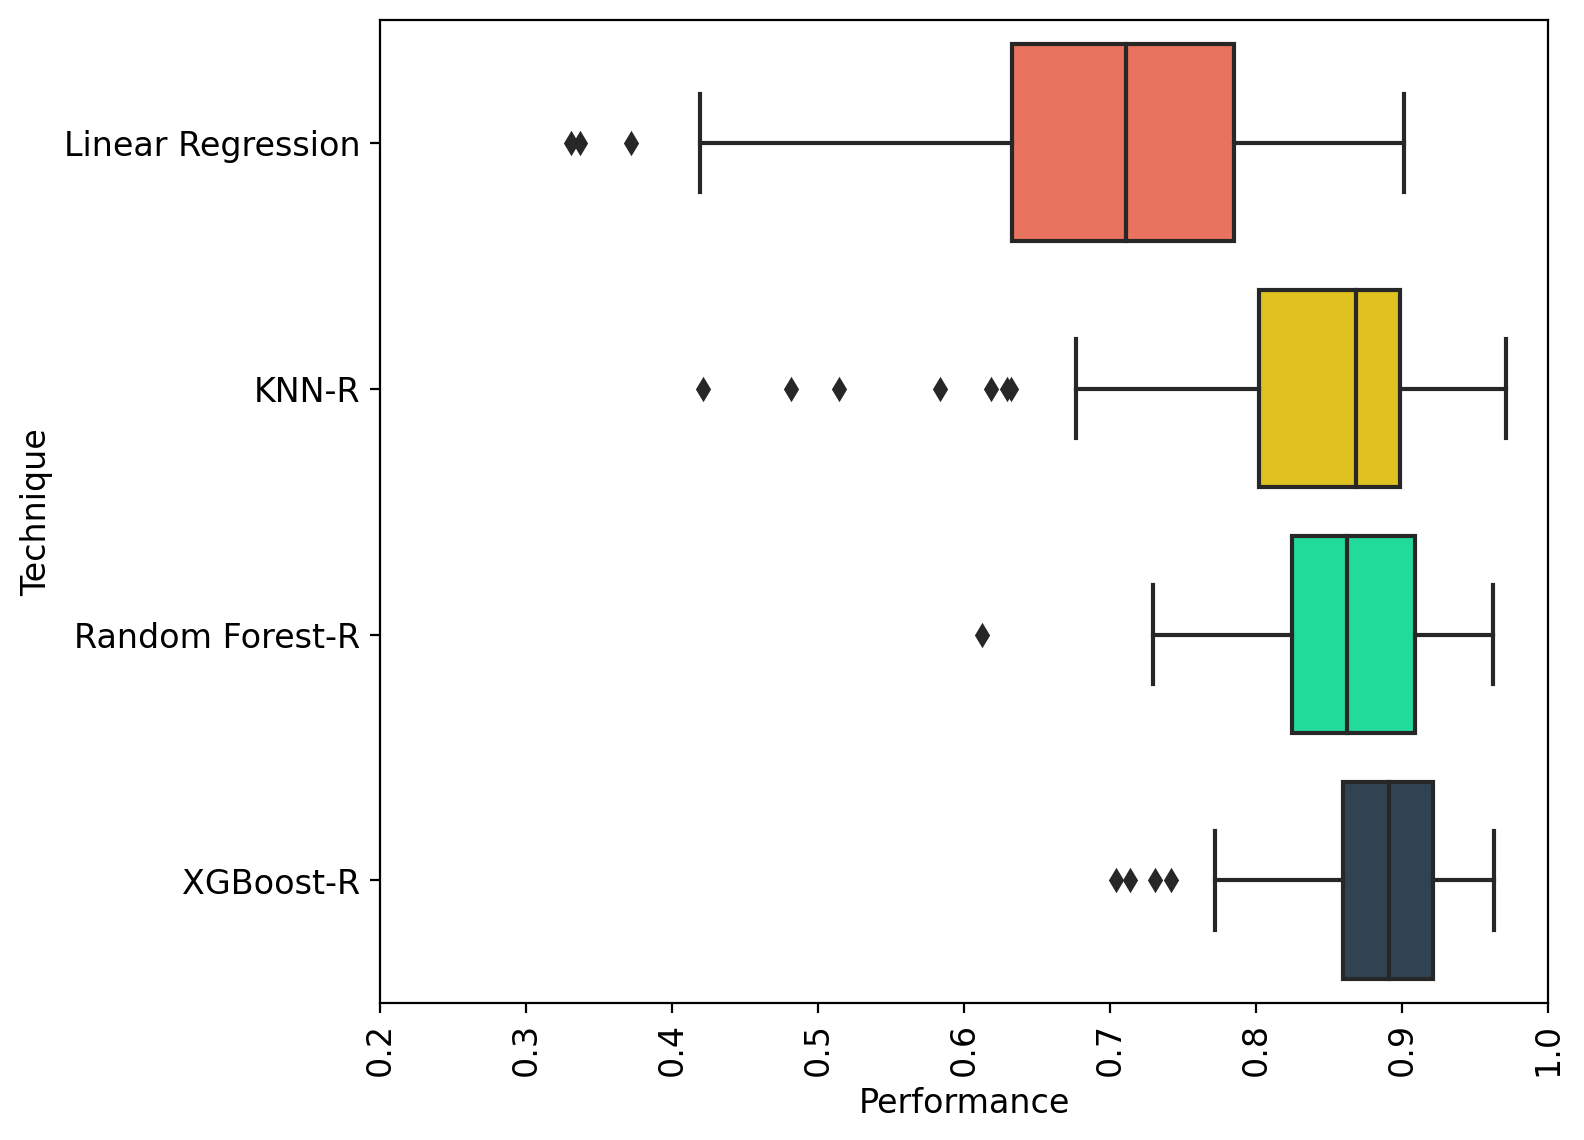

In [113]:
import matplotlib.colors as mcolors
from matplotlib.pyplot import figure
data = pd.DataFrame({
    'Technique': np.repeat(['Linear Regression', 'KNN-R', 'Random Forest-R', 'XGBoost-R'], 100),
    'Performance': np.concatenate([
                score_linear,
                score_KNN,
                score_RF,
                score_XGB
    ])
})
figure(figsize=(8, 6), dpi=200)
plt.rcParams.update({'font.size': 12})
# Crear el diagrama de caja y bigotes
colors = [mcolors.to_rgba('tomato'), mcolors.to_rgba('gold'), mcolors.to_rgba('#02faa3'), mcolors.to_rgba('#2a4359')]
sns.boxplot(x='Performance', y='Technique', data=data, orient='h', palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()
plt.xlim((0.2, 1))
# Guardar la figura con resolución de 300 dpi
plt.savefig('diagrama_de_caja.png', dpi=300)
plt.show()

In [118]:
np.mean(mse_XGB)

4.560234295050859

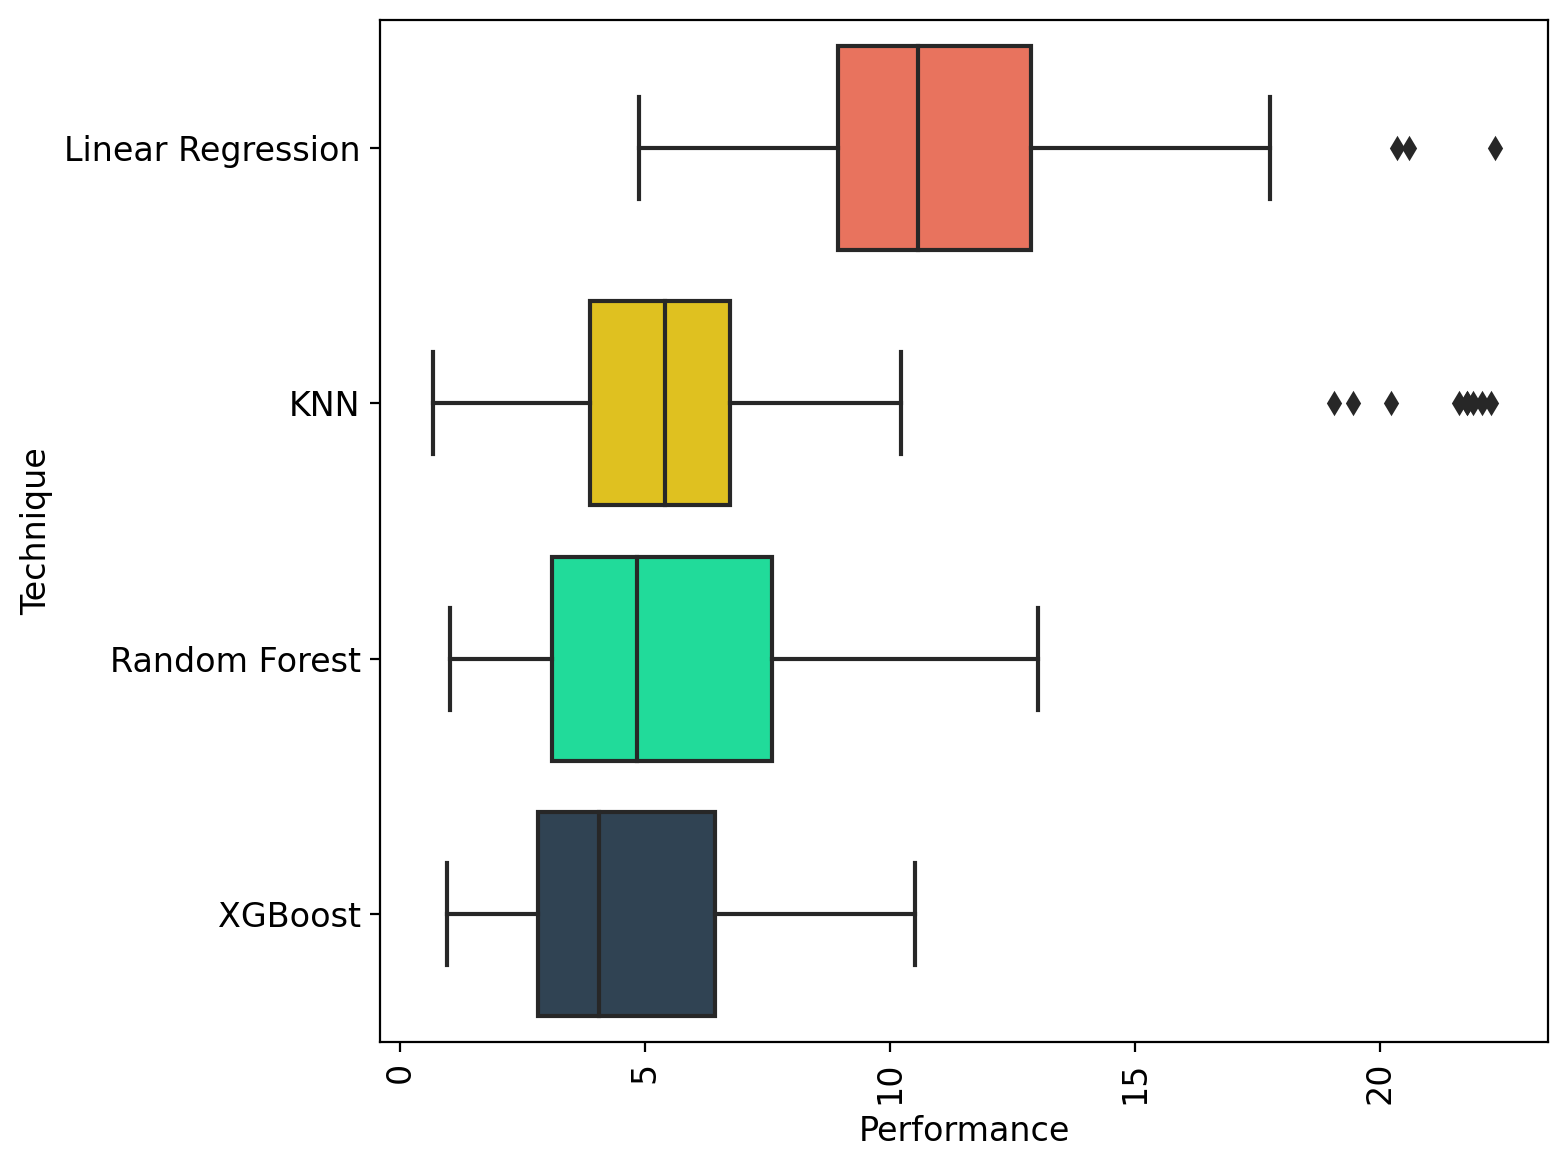

In [116]:
data_MSE = pd.DataFrame({
    'Technique': np.repeat(['Linear Regression', 'KNN', 'Random Forest', 'XGBoost'], 100),
    'Performance': np.concatenate([
                mse_linear,
                mse_KNN,
                mse_RF,
                mse_XGB
    ])
})
figure(figsize=(8, 6), dpi=200)
plt.rcParams.update({'font.size': 12})
# Crear el diagrama de caja y bigotes
colors = [mcolors.to_rgba('tomato'), mcolors.to_rgba('gold'), mcolors.to_rgba('#02faa3'), mcolors.to_rgba('#2a4359')]
sns.boxplot(x='Performance', y='Technique', data=data_MSE, orient='h', palette=colors)
plt.xticks(rotation=90)
plt.tight_layout()
# Guardar la figura con resolución de 300 dpi
plt.savefig('diagrama_de_caja_mse.png', dpi=300)
plt.show()

In [108]:
data

,Technique,Performance
0,Linear Regression,0.576102
1,Linear Regression,0.774817
2,Linear Regression,0.716525
3,Linear Regression,0.677672
4,Linear Regression,0.330831
...,...,...
395,XGBoost,0.809408
396,XGBoost,0.884859
397,XGBoost,0.824473
398,XGBoost,0.899234


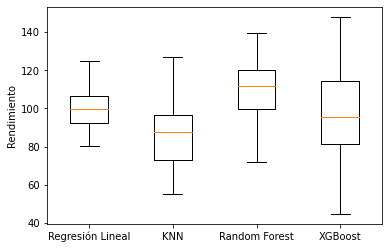

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
regresion_lineal = np.random.normal(100, 10, 50)
knn = np.random.normal(90, 20, 50)
random_forest = np.random.normal(110, 15, 50)
xgboost = np.random.normal(95, 25, 50)

# Crear una lista con los datos para cada algoritmo
datos = [regresion_lineal, knn, random_forest, xgboost]

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Crear el diagrama de caja y bigotes
ax.boxplot(datos)

# Añadir etiquetas a los ejes
ax.set_xticklabels(['Regresión Lineal', 'KNN', 'Random Forest', 'XGBoost'])
ax.set_ylabel('Rendimiento')

# Mostrar el diagrama
plt.show()